In [1]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.25

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    PLOT_CONFIG,
    save_factory,
)
from copy import deepcopy
from operator import or_
from toolz import reduce
from aging.behavior.bio_age_model import fit_model, constrained_fit
from scipy.stats import spearmanr
from aging.organization.dataframes import zscore
from datetime import timedelta
from statsmodels.stats.multitest import multipletests

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, median_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.25


In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig4-longv1-lab-comments", tight_layout=False)

In [3]:
to_remove = [
    "e4f1076b",
    "3867c517",
    "60e82cb4",
]

def load_male_long_df(average_weeks=False, merge_size=True, merge_ages=False):
    keep_syllables = np.loadtxt(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
        dtype=int,
    )
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_raw_counts_matrix_v00.parquet"
    )

    df = df[keep_syllables]

    masks = [df.index.get_level_values("age") > 100]
    for uuid in to_remove:
        m = df.reset_index()["uuid"].str.startswith(uuid)
        masks.append(m)
    mask = np.array(reduce(or_, masks), dtype=bool)
    df = df[~mask].copy()

    if merge_size:
        size_df = pd.read_parquet(
            "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_mouse_area_df_v00.parquet"
        )
        df = df.join(size_df[["quant_0.5"]])

        df.loc[df["quant_0.5"] == 0, "quant_0.5"] = np.nan

        if df['quant_0.5'].isna().sum() > 0:
            df["quant_0.5"] = (
                df["quant_0.5"].groupby("mouse")
                .transform(lambda df: df.sort_index(level="age").interpolate())
            )

    if average_weeks:
        rsdf = df.reset_index()
        start_date = rsdf['date'].min()
        end_date = rsdf['date'].max() + timedelta(days=1)

        dt = pd.date_range(start_date, end_date, freq='D')

        date_df = pd.DataFrame(dict(dow=dt.day_of_week), index=dt.date)
        cycle = date_df.diff()['dow'] < 0
        date_df['week'] = (cycle.cumsum().rename('week') // 2) * 2

        long_df_dates = pd.Series(df.index.get_level_values('date'), index=df.index, name='week')
        df['week'] = long_df_dates.map(lambda x: date_df.loc[x.date(), 'week'])

        if merge_ages:
            df = df.reset_index(level='age')
            df['age'] = df.groupby('week')['week'].transform(lambda x: x + 3)
            df = df.set_index(['age', 'week'], append=True)
        else:
            df = df.set_index('week', append=True)

        new_df = []
        for (mouse, week), _df in df.groupby(['mouse', 'week'], observed=True):
            _df = _df.reset_index(level='age')
            if len(_df) > 2:
                _df = _df.iloc[:2]
            if len(_df) == 1:
                new_df.append(_df.iloc[[0]])
            else:
                _tmp_df = pd.DataFrame(_df.mean()).T
                _tmp_df.index = _df.index[[0]]
                new_df.append(_tmp_df)

        new_df = pd.concat(new_df).set_index('age', append=True)

        if merge_size:
            age_cut = pd.cut(new_df.index.get_level_values("age"), 21)
            new_df["quant_0.5"] = new_df.groupby(age_cut, observed=True)["quant_0.5"].transform(zscore)
            new_df["quant_0.5"] = new_df["quant_0.5"].fillna(0)

        return new_df

    if merge_size:
        age_cut = pd.cut(df.index.get_level_values("age"), 21)
        df["quant_0.5"] = df.groupby(age_cut, observed=True)["quant_0.5"].transform(zscore)
        df["quant_0.5"] = df["quant_0.5"].fillna(0)

    return df


def load_long_df2(average_weeks=True):
    df = load_male_long_df(average_weeks=average_weeks, merge_ages=False)

    age = jnp.array(df.index.get_level_values("age"))

    label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
    mouse_ids = label_encoder.fit_transform(
        df.index.get_level_values("mouse").to_numpy()[:, None]
    ).T

    sizes_col = df['quant_0.5']
    df = df.drop(columns=['quant_0.5'])
    syllable_counts_jax = jnp.array(df.astype(float))
    sort_idx = np.argsort(syllable_counts_jax.sum(0))[::-1]

    return df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx, label_encoder


def compute_classifier(df, seed=0):
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", class_weight="balanced", random_state=seed),
    )

    preds = cross_val_predict(
        pipe,
        df[["beh_age"]],
        df["classes"],
        cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=seed),
    )
    return accuracy_score(df["classes"], preds), preds


def make_death_df(reset_df, min_age, max_age, n_classes=4):

    joined = reset_df[reset_df['age'].between(min_age, max_age)].merge(
        death_map.reset_index(), left_on="mouse", right_on="id"
    ).dropna(subset=["Death"])

    classes = pd.qcut(joined["Death"], n_classes, labels=False)
    joined['classes'] = classes
    return joined


def fit_classifier(data, n_fits=100, n_classes=4):
    accs = []
    for seed in range(n_fits):
        acc, p = compute_classifier(data, seed=seed)
        accs.append(acc)
    print("Observed fit")
    print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

    # shuffle
    shuffs = []
    for i in tqdm(range(n_fits)):
        shuff_df = data.copy()
        shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
        # shuffle ages within age chunks rather than across everything to remove individual biases
        acc, p = compute_classifier(shuff_df, seed=i)
        shuffs.append(acc)
    print("Shuffle fit")
    print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))
    return accs, shuffs


def plot_model(accs, shuffs, name, n_classes=4):
    fig = figure(0.55, 1.3)
    ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
    ax.axhline(1 / n_classes, color='k', ls='--')
    ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.4))
    ax.tick_params(axis='x', rotation=90)
    sns.despine()
    saver(fig, name)

## Load the death predictor data

In [4]:
death_df = pd.read_csv('/home/wg41/code/ontogeny/notebooks/exploration/win/death-predictor/death-predictor-data.csv').ffill()
death_df['Death'] = pd.to_datetime(death_df['Death'])

death_map = death_df.set_index('id')[['Death']].drop('04_02')
death_map['death_rank'] = death_map['Death'].rank()

In [5]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[use_syllables]
    df = df.query('age < 100')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v00.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = size_df.groupby('age')['quant_0.5'].transform(zscore)
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col

In [6]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df, sizes_col = read_male_ontogeny(keep_syllables)

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

In [7]:
# use ontogeny males to fit age and size factors of bambi model
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy()
}

age_sd = 0.125

hypparams = {
    "log_age": True,
    "min_age": 2,
    "max_age": 125,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.25,
    "n_opt_iter": 150,
    "log_scale_sd": True,
}

In [8]:
(
    tmp_df,
    long_syllable_counts_jax,
    long_age,
    long_size_col,
    long_mouse_ids,
    sort_idx,
    long_labels,
) = load_long_df2()

In [9]:
long_features = {
    "ages": jnp.array(long_age, dtype=jnp.float32),  # models >= 1
    "counts": long_syllable_counts_jax + 1,  # models >= 1
    "sizes": jnp.array(long_size_col),
    "mice": jnp.array(long_mouse_ids),
}

long_hypparams = deepcopy(hypparams)
long_hypparams["n_animals"] = len(long_mouse_ids)
# long_hypparams['n_opt_iter'] = 160
long_hypparams['n_opt_iter'] = 200
long_hypparams['age_sd'] = 0.18

# this forces the identity factors to incorporate an experiment-specific
# syllable offset to account for "batch effects"
# long_hypparams['zero_mean'] = True
long_hypparams['zero_mean'] = False

mdl1 = fit_model(features, hypparams, 2)
mdl1_mask= mdl1['true_ages'] > 45
fixed_params = mdl1['params']
print(round(median_absolute_error(mdl1['true_ages'][mdl1_mask], mdl1['bio_ages'][mdl1_mask]), 2))

# fit identity parameter for longtogeny model
long_mdl = constrained_fit(long_features, fixed_params, long_hypparams, 5, return_loss_on_error=False)
mask = long_mdl['true_ages'] > 45

_resid = long_mdl['true_ages'] - long_mdl['bio_ages']
_resid = _resid[mask]

tmp_df['beh_age'] = long_mdl['bio_ages']
subset = make_death_df(tmp_df.reset_index(), 56, 71)

c = subset[['death_rank', 'beh_age']].corr(method='spearman').iloc[0, 1]

median_absolute_error(long_mdl['true_ages'][mask], long_mdl['bio_ages'][mask])

2.74


5.5412827

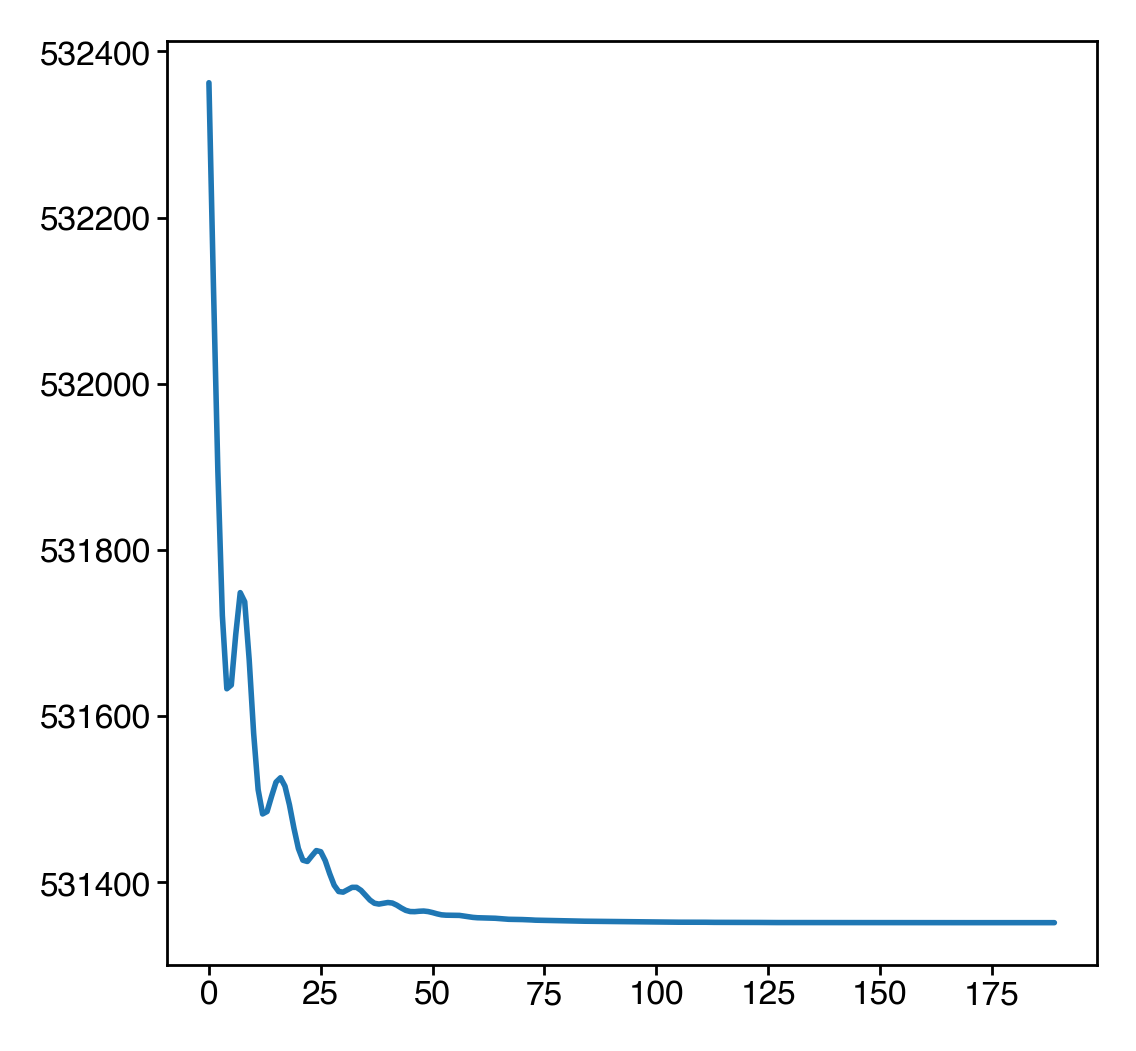

In [10]:
plt.plot(long_mdl['loss'][10:])

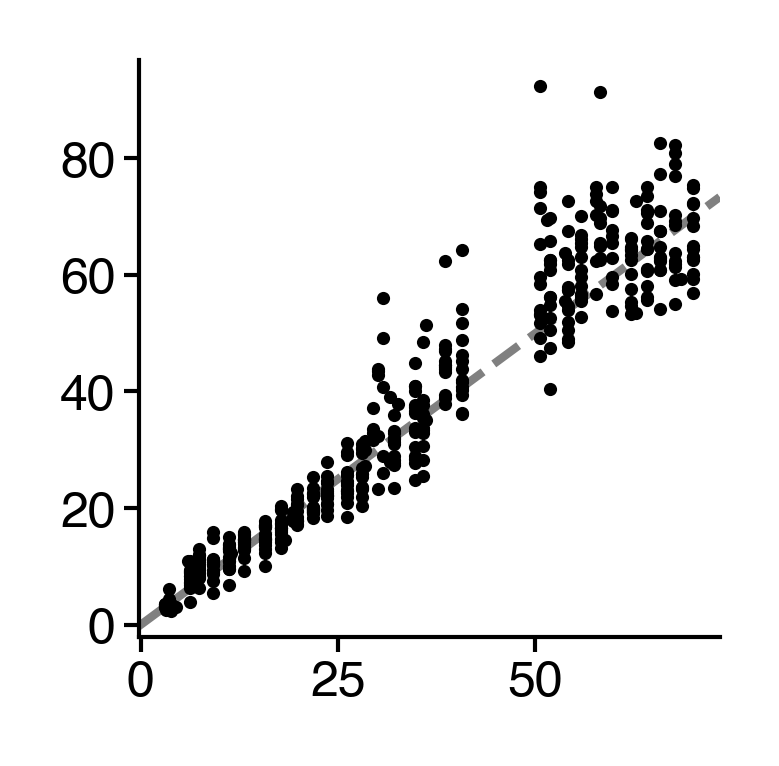

In [11]:
fig = figure(1.25, 1.25)
plt.scatter(long_mdl['true_ages'], long_mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

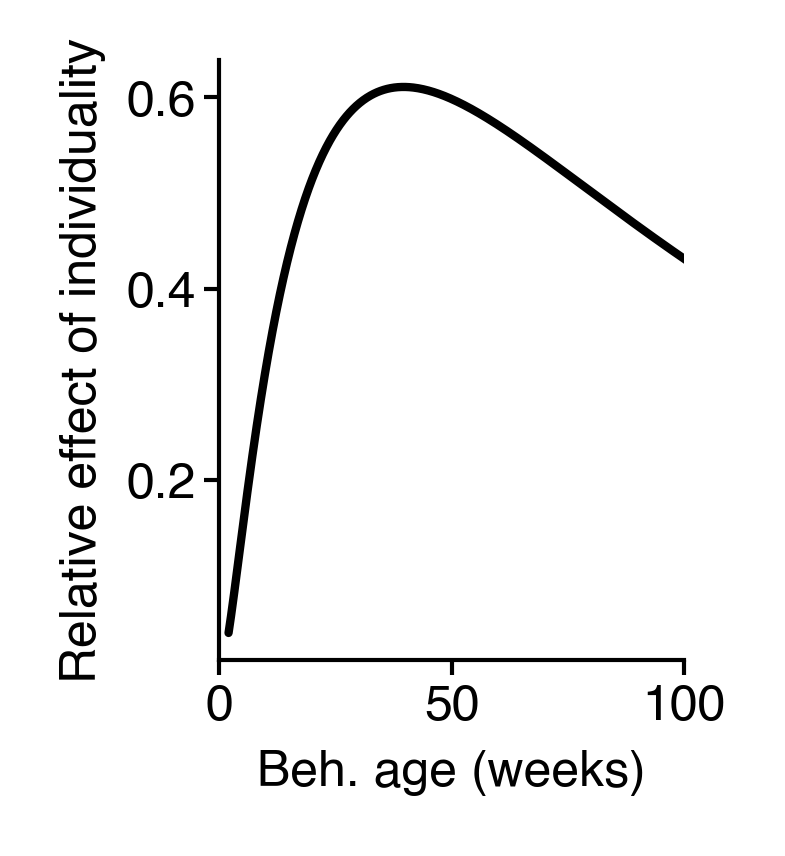

In [12]:
comps = long_mdl['init_components']

x = long_mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of individuality")
sns.despine()
# saver(fig, "lontogeny-effect-of-individuality");

## Try classifying early/late death times 

Observed fit
4 0.48


  0%|          | 0/1000 [00:00<?, ?it/s]

Shuffle fit
4 -0.06


/tmp/ipykernel_27145/106652125.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.4))


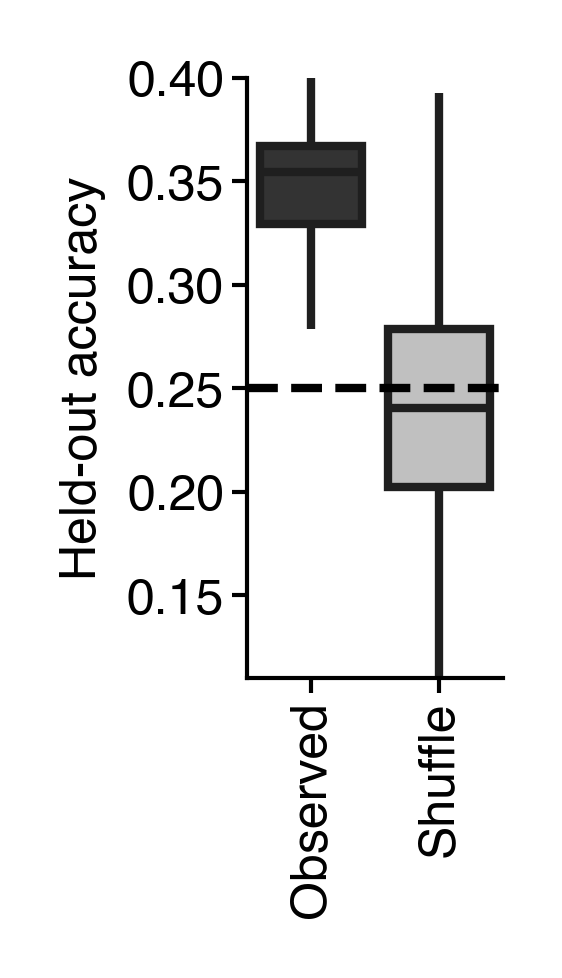

In [13]:
subset = make_death_df(tmp_df.reset_index(), 56, 71)
accs, shuffs = fit_classifier(subset, n_fits=1_000)
plot_model(accs, shuffs, "death-rank-classifier-via-bambi")

In [14]:
# significance of observed data
np.mean(np.array(shuffs) > np.mean(accs))

0.036

In [15]:
spearmanr(subset['classes'], subset['beh_age'])

SignificanceResult(statistic=-0.2809736933373304, pvalue=0.012131594689664458)

In [16]:
subset[['classes', 'beh_age']].corr(method='spearman')

,classes,beh_age
classes,1.000000,-0.280974
beh_age,-0.280974,1.000000


In [17]:
subset[['death_rank', 'beh_age']].corr(method='spearman')

,death_rank,beh_age
death_rank,1.000000,-0.249582
beh_age,-0.249582,1.000000


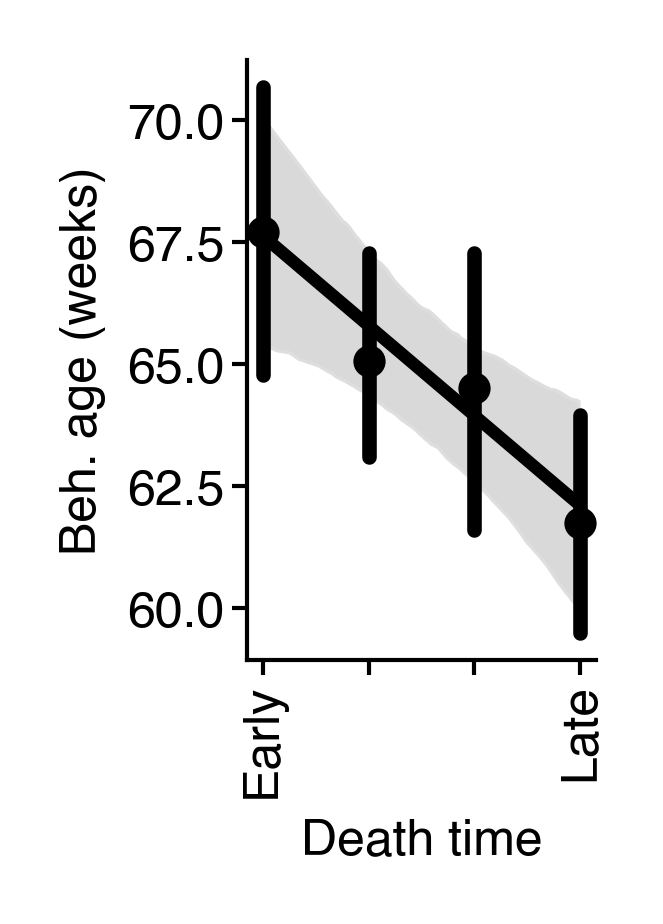

In [18]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "bambi-beh-age-vs-death");

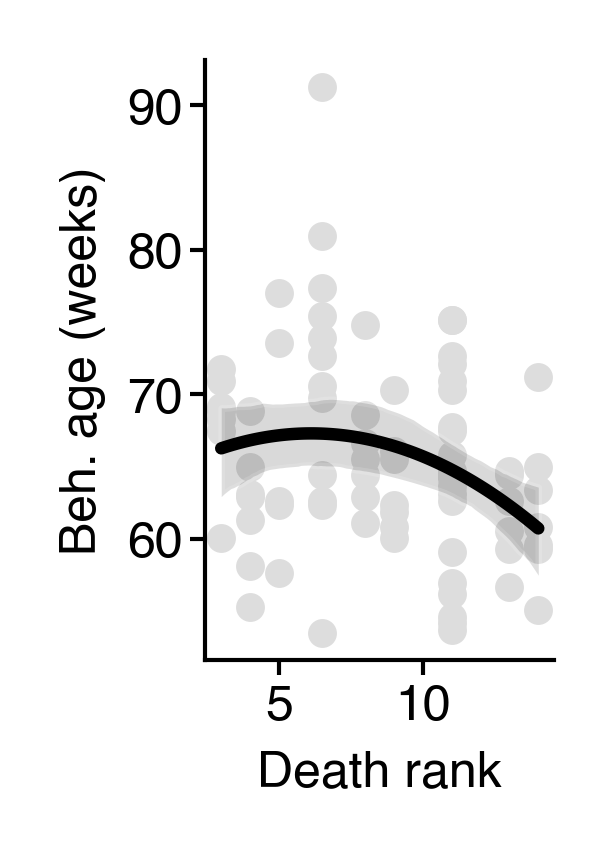

In [19]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='death_rank', y='beh_age', scatter_kws=dict(s=12, linewidths=0, color='#ddd', alpha=1), color='k', order=2)
ax.set(ylabel="Beh. age (weeks)", xlabel="Death rank")
sns.despine()

### Younger ages

Observed fit
4 -0.07


  0%|          | 0/1000 [00:00<?, ?it/s]

Shuffle fit
4 -0.03


/tmp/ipykernel_27145/106652125.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.4))


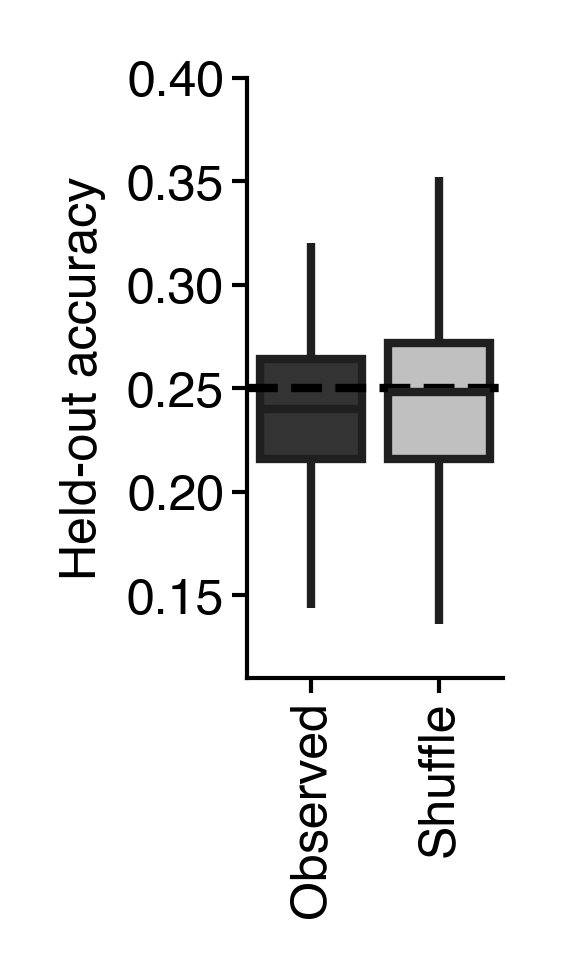

In [20]:
subset = make_death_df(tmp_df.reset_index(), 0, 20)
accs, shuffs = fit_classifier(subset, n_fits=1_000)
plot_model(accs, shuffs, "young-age-death-rank-classifier-via-bambi")

In [21]:
# significance of observed data
np.mean(np.array(shuffs) > np.mean(accs))

0.579

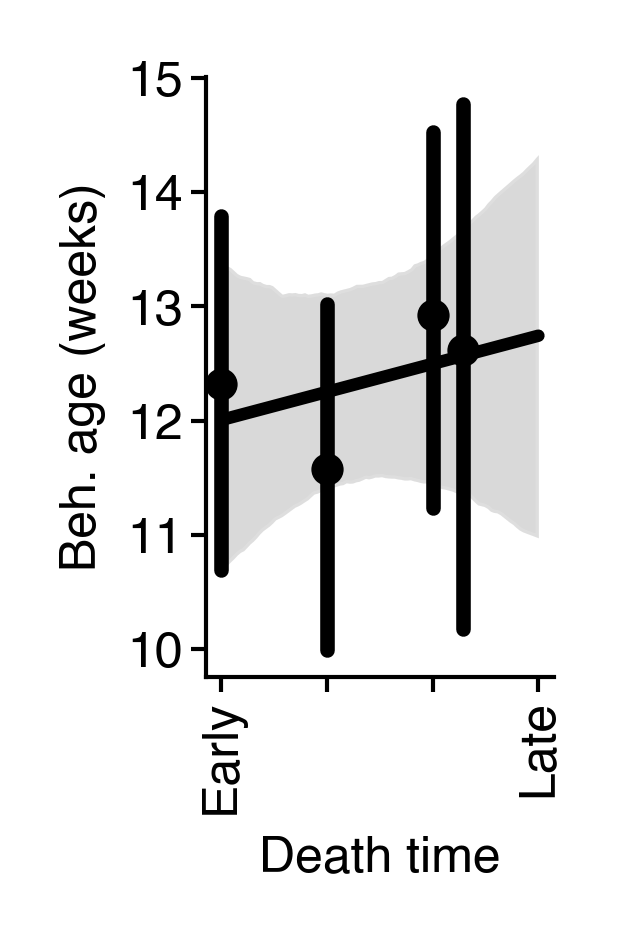

In [22]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "bambi-young-beh-age-vs-death");

### Middler ages

Observed fit
4 0.21


  0%|          | 0/1000 [00:00<?, ?it/s]

Shuffle fit
4 -0.03


/tmp/ipykernel_27145/106652125.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.4))


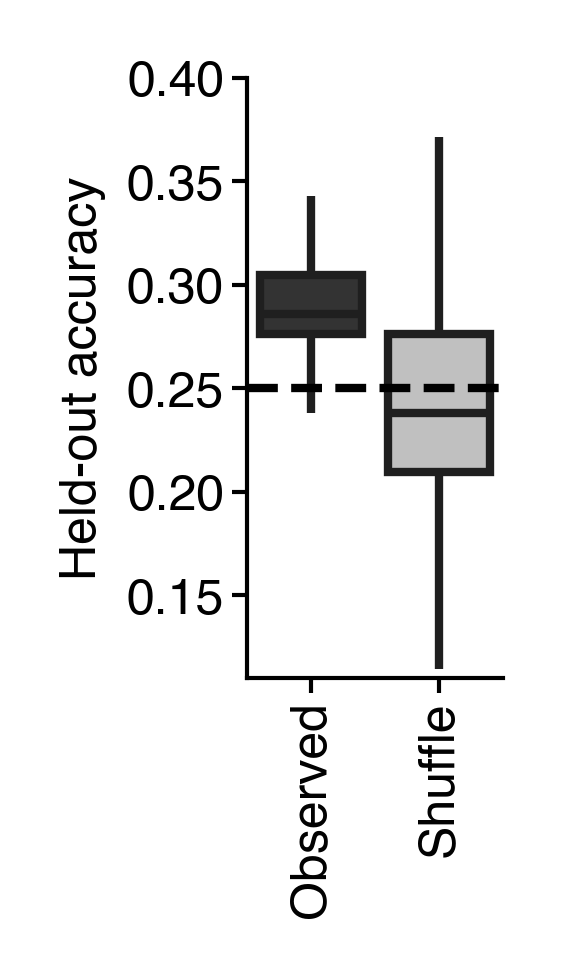

In [23]:
subset = make_death_df(tmp_df.reset_index(), 20, 37)
accs, shuffs = fit_classifier(subset, n_fits=1_000)
plot_model(accs, shuffs, "mid-age-1-death-rank-classifier-via-bambi")

In [24]:
# significance of observed data
np.mean(np.array(shuffs) > np.mean(accs))

0.196

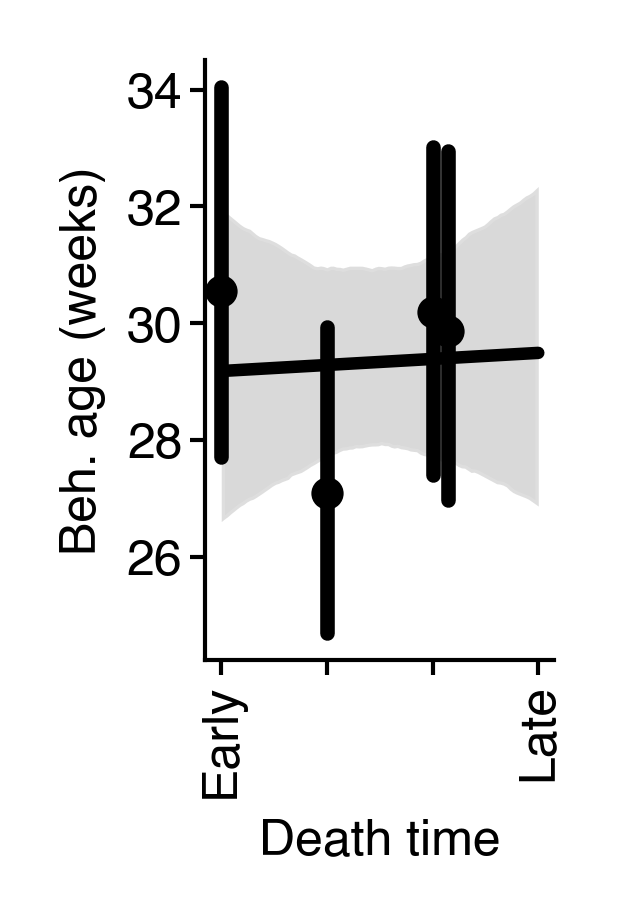

In [25]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "bambi-mid-1-beh-age-vs-death");

Observed fit
4 0.33


  0%|          | 0/1000 [00:00<?, ?it/s]

Shuffle fit
4 -0.0


/tmp/ipykernel_27145/106652125.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.4))


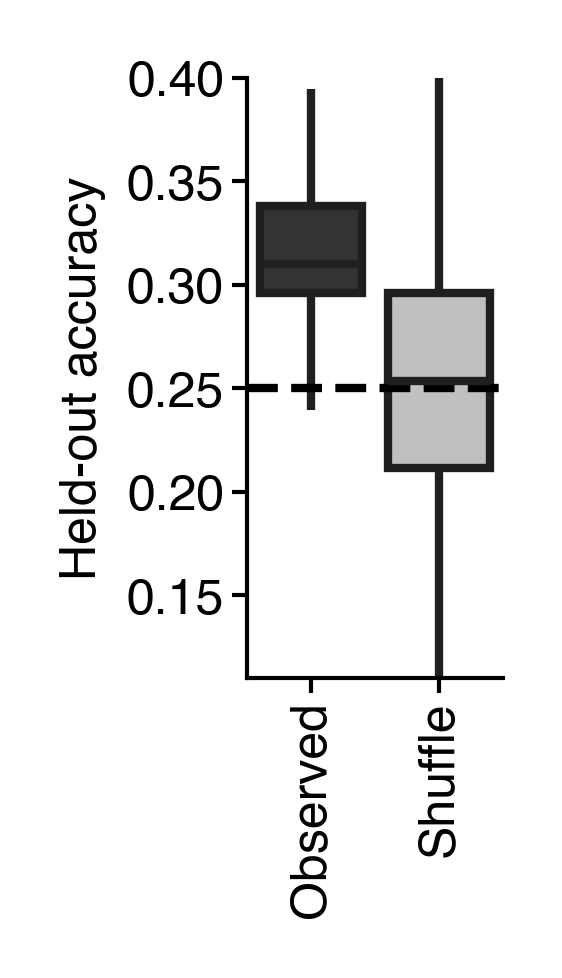

In [26]:
subset = make_death_df(tmp_df.reset_index(), 37, 56)
accs, shuffs = fit_classifier(subset, n_fits=1_000)
plot_model(accs, shuffs, "mid-age-2-death-rank-classifier-via-bambi")

In [27]:
# significance of observed data
np.mean(np.array(shuffs) > np.mean(accs))

0.117

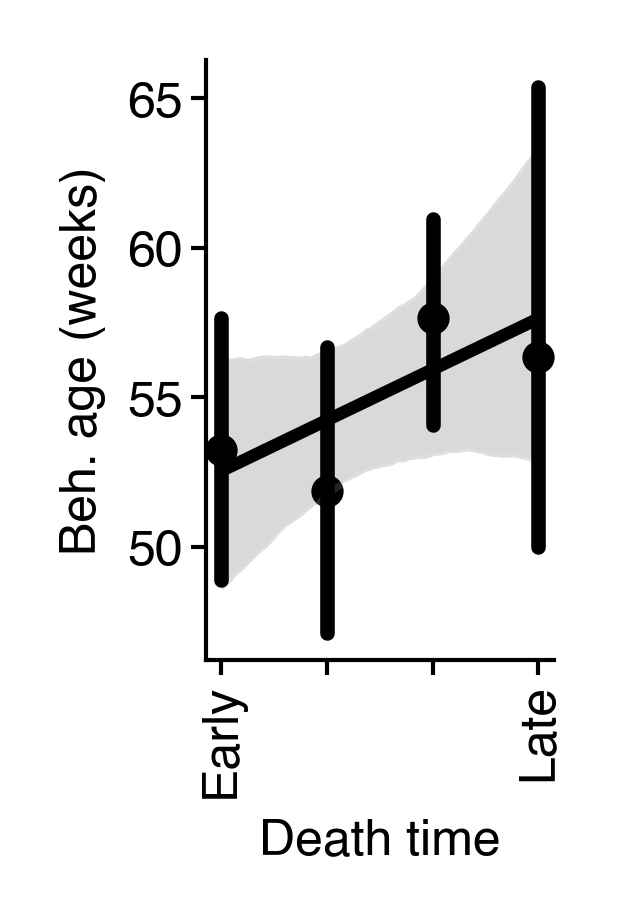

In [28]:
fig = figure(0.75, 1.3)
ax = sns.regplot(data=subset, x='classes', y='beh_age', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="Beh. age (weeks)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "bambi-mid-2-beh-age-vs-death");

### Correlate bio age with syllable use

In [29]:
reset_df = tmp_df.reset_index()
subset = reset_df[reset_df['age'].between(56, 71)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], 4, labels=False)
subset_join['classes'] = classes
subset_join.shape

In [31]:
subset_join.head()

,mouse,subject_name,session_name,uuid,date,week,age,0,2,4,...,90,93,95,97,98,beh_age,id,Death,death_rank,classes
0,01_01,01_01_207,207,7bfa81df-b55f-4094-ba70-95791afb1e63,2022-04-17 14:45:50,54,58.214287,5.0,68.5,72.5,...,99.5,8.5,25.5,13.5,56.0,62.617802,01_01,2023-12-04,11.0,2
1,01_01,01_01_209,209,279bcc86-ae29-4b82-9c7f-b8238795aa02,2022-05-01 14:21:16,56,59.714287,2.0,62.0,123.0,...,68.0,7.0,46.0,9.0,62.0,53.725918,01_01,2023-12-04,11.0,2
2,01_01,01_01_210,210,afc391f4-02af-4132-ac17-1d69dc06bcb9,2022-05-14 17:48:22,58,62.142860,5.5,54.0,113.0,...,61.0,12.5,31.0,11.0,62.0,64.726074,01_01,2023-12-04,11.0,2
3,01_01,01_01_212,212,4f5cf67f-fd37-44eb-9cdf-71baeff649f6,2022-06-01 11:47:32,60,64.142860,11.0,39.0,75.0,...,43.0,9.0,26.0,13.0,65.0,65.806679,01_01,2023-12-04,11.0,2
4,01_01,01_01_213,213,d6393e2e-a99f-42c4-815b-aab37ac25504,2022-06-12 15:30:03,62,65.714287,3.0,36.0,43.0,...,109.0,9.0,7.0,19.0,50.0,67.461525,01_01,2023-12-04,11.0,2


In [32]:
subset_join.columns = [str(x) for x in subset_join.columns]

In [33]:
syll_cols = [x for x in subset_join.columns if x.isdigit()]

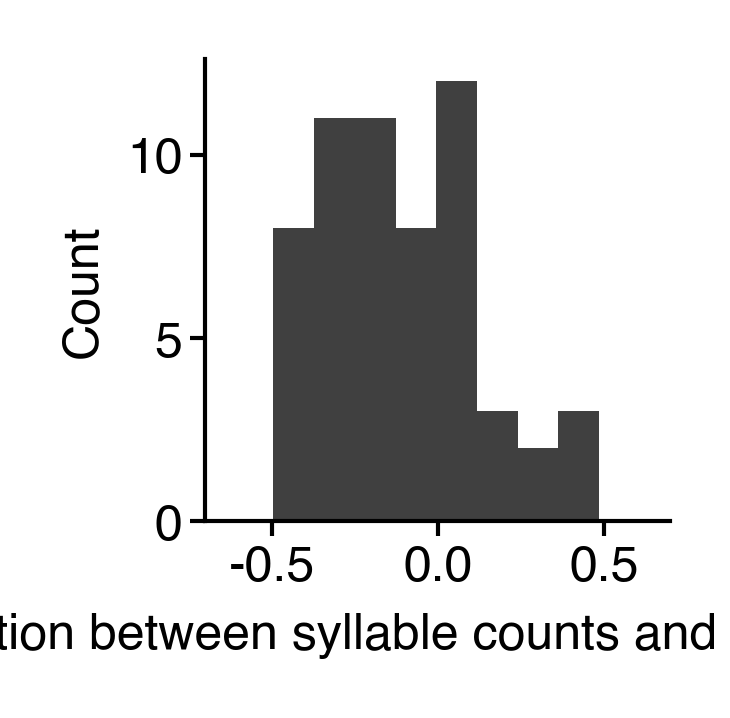

In [34]:
fig = figure(1, 1)
ax = sns.histplot(
    subset_join[syll_cols + ["beh_age"]]
    .corr(method="spearman")
    .loc["beh_age"]
    .drop("beh_age"),
    element="step",
    lw=0,
    color="k",
    bins=8,
)
ax.set(xlabel="Correlation between syllable counts and beh. age (rho)", xlim=(-0.7, 0.7))
sns.despine()
saver(fig, "counts-vs-bambi-beh-age-correlation");

In [35]:
lm_corrs = subset_join[syll_cols + ['beh_age']].corr(method='spearman').loc['beh_age'].sort_values().drop('beh_age')
lm_corrs

In [37]:
pd.DataFrame(lm_corrs).to_parquet('/n/scratch/users/w/wg41/bambi_syll_death_corrs.parquet')

In [ ]:
# for syll in lm_corrs.index[[0, 1, 2, 3, 4, 28, 29, 30, 31, 35, 36, 37, -5, -4, -3, -2, -1]]:
for syll in lm_corrs.index:
    fig = figure(0.6, 0.8)
    syll_corr = lm_corrs[syll]
    ax = sns.regplot(
        data=subset_join,
        y=syll,
        x="beh_age",
        scatter_kws=dict(s=10, linewidths=0.3, color="silver", edgecolor="k", alpha=1),
        color="k",
    )
    ax.set(
        title=f"Syllable {syll}; rho={syll_corr:0.2f}",
        xlabel="Beh. age (weeks)",
        ylabel="Syllable counts",
    )
    sns.despine()
    saver(fig, f"syll-{syll}-bambi-age-vs-counts")

## Compare bambi syllable derivatives with syllable/death correlations

In [39]:
bio_base = long_mdl['init_components'].bases['bio']

deriv_df = []
for syllable in tmp_df.columns[:-1]:

    mtx_idx = list(tmp_df.columns).index(syllable)
    weights = long_mdl['params']['bio_basis_weights'][mtx_idx]
    curve = np.exp(weights @ bio_base)
    age_range = long_mdl['init_components'].age_normalizer(np.array([50, 70]))

    norm_ages = pd.Series(np.linspace(0, 1, len(curve)))
    sig = norm_ages.between(*age_range)
    sig_mask = sig[sig]
    start_idx, end_idx = sig_mask.index[[0, -1]]
    deriv = (curve[end_idx] - curve[start_idx]) / (norm_ages[sig].iloc[-1] - norm_ages[sig].iloc[0])
    deriv_df.append(dict(deriv=deriv, syllable=syllable))

deriv_df = pd.DataFrame(deriv_df).set_index('syllable')
lm_corrs.index.name = 'syllable'
lm_corrs.index = lm_corrs.index.astype(int)
joined_corr_df = deriv_df.join(lm_corrs).rename(columns={"beh_age": "correlation"})

<Axes: xlabel='correlation', ylabel='deriv'>

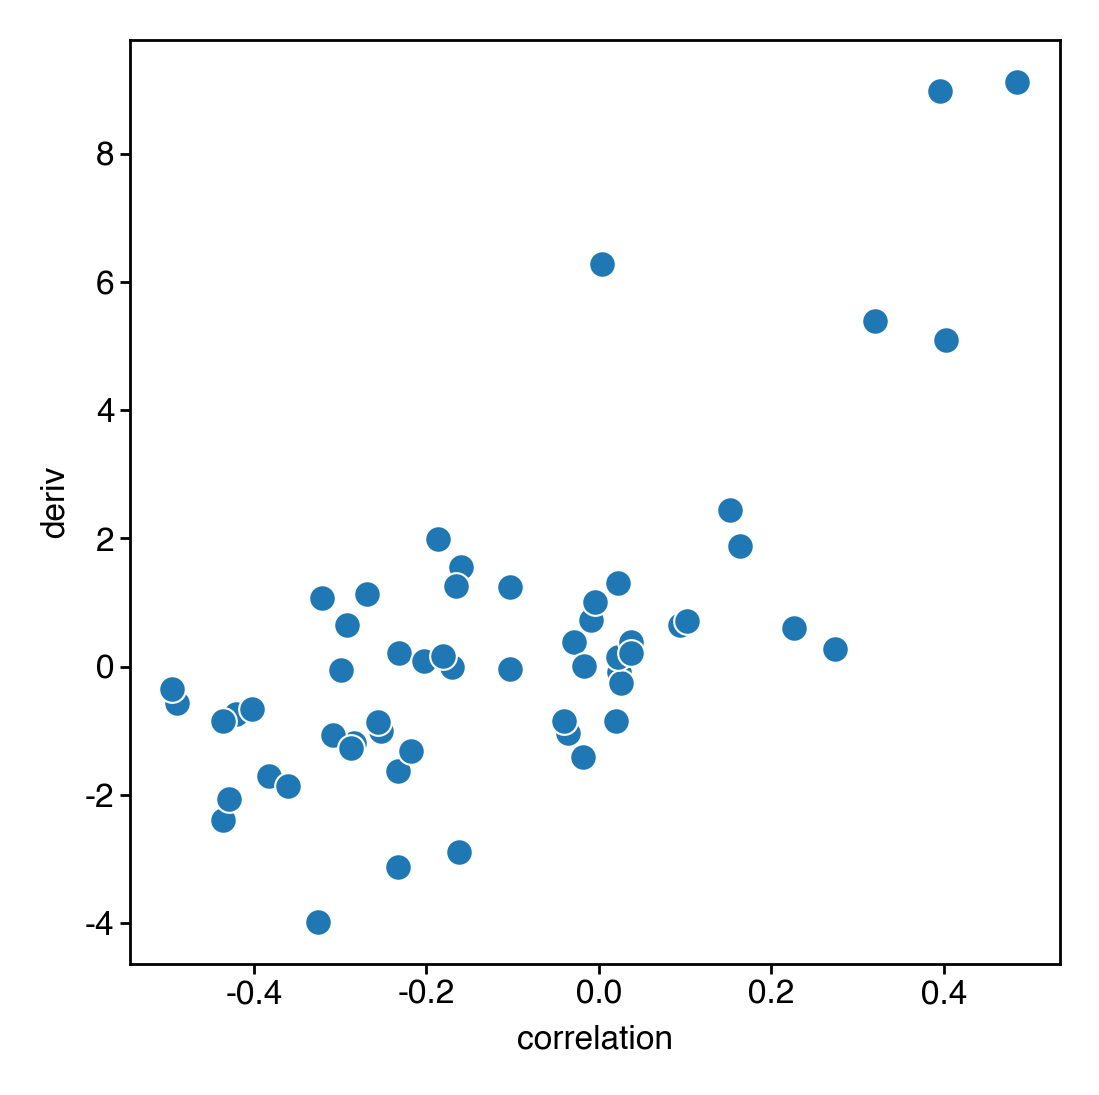

In [43]:
sns.scatterplot(data=joined_corr_df, x="correlation", y="deriv")

## Compute correlation between death time and syllable use

In [44]:
subset = make_death_df(tmp_df.reset_index(), 56, 71)

In [45]:
syll_cols = [x for x in subset.columns if str(x).isdigit()]

In [46]:
corr_and_p = []
for s in syll_cols:
    res = spearmanr(subset[s], subset['classes'])
    corr_and_p.append(dict(syllable=s, c=res.statistic, p=res.pvalue))
corr_and_p = pd.DataFrame(corr_and_p)
corr_and_p['adj_p'] = multipletests(corr_and_p['p'].to_numpy(), method='bonferroni')[1]

joined_corr_df = pd.DataFrame(lm_corrs).merge(corr_and_p, left_index=True, right_on='syllable')

In [53]:
lc_p = {}
for s in syll_cols:
    lc_p[s] = spearmanr(subset_join[str(s)], subset_join['beh_age']).pvalue

In [55]:
joined_corr_df['syll_beh_age_p'] = [lc_p[i] for i in joined_corr_df['syllable']]
joined_corr_df['syll_beh_age_adj_p'] = multipletests(joined_corr_df['syll_beh_age_p'].values, method='bonferroni')[1]

In [60]:
joined_corr_df.rename(columns={'p': 'syll_death_p', 'c': 'syll_death_c', 'beh_age': 'syll_beh_age_c'}).to_csv('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/stats/long-v1-syllable-death-correlations.csv')

In [56]:
corr = joined_corr_df.corr(method="spearman").loc["beh_age", "c"]

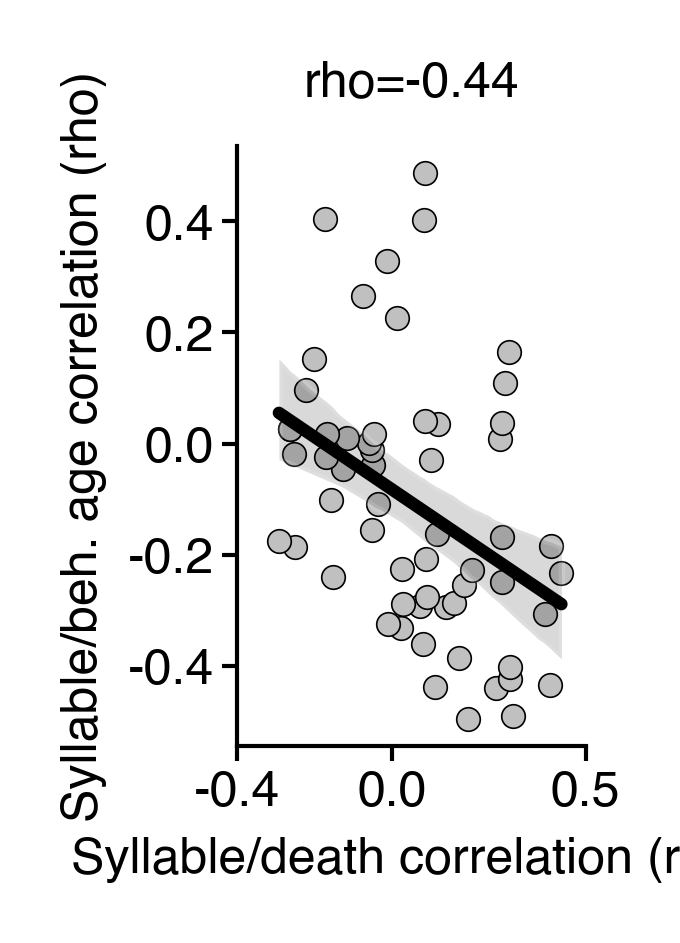

In [49]:
fig = figure(0.75, 1.3)
ax = sns.regplot(
    data=joined_corr_df,
    x="c",
    y="beh_age",
    scatter_kws=dict(linewidths=0.2, s=8, color='silver', edgecolor='k', alpha=1),
    color="k",
    robust=False,
    n_boot=400,
)

ax.set(
    xticks=(-0.4, 0, 0.5),
    xlim=(-0.4, 0.5),
    ylabel="Syllable/beh. age correlation (rho)",
    title=f"rho={corr:0.2f}",
    xlabel="Syllable/death correlation (rho)",
)
sns.despine()
saver(fig, "bambi-vs-syllable-correlation");

## Show relationship between syllable use and time of death

In [50]:
syll_idx = corr_and_p.sort_values(by='c')['syllable'].values
syll_idx_corr = corr_and_p.set_index('syllable')

In [51]:
def plot_syll_and_death(syllable):
    _corr = syll_idx_corr.loc[int(syllable), 'c']
    fig = figure(0.65, 1.3)
    ax = sns.regplot(
        data=subset.reset_index().rename(columns=str),
        x="classes",
        y=str(syllable),
        robust=False,
        n_boot=100,
        x_bins=6,
        color='k',
        scatter_kws=dict(s=18, lw=0),
    )
    ax.set(xticks=[0, 3], xticklabels=['Early', 'Late'], xlabel="Time of death", ylabel="Counts", title=f"Syll {syllable}; rho={_corr:0.2f}")
    sns.despine()
    return fig

In [ ]:
for syll in lm_corrs.index:
    fig = plot_syll_and_death(syll)
    saver(fig, f"time-of-death-syllable-use-{syll}")

## Velocity vs time of death

In [54]:
import polars as pl

In [55]:
vel_df = pl.scan_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_syllable_df_v00.parquet')

In [56]:
vel_df.head().collect()

experiment,file,uuid,date,age,syllables,pc_00,pc_01,pc_02,pc_03,pc_04,pc_05,pc_06,pc_07,pc_08,pc_09,true_depth,session_name,subject_name,timestamps,raw_timestamps,area_mm,area_px,centroid_x_mm,centroid_x_px,centroid_y_mm,centroid_y_px,height_ave_mm,length_mm,length_px,velocity_2d_mm,velocity_2d_px,velocity_3d_mm,velocity_3d_px,width_mm,width_px,angle,velocity_theta,recon_width,recon_length,recon_height,recon_area,onsets,mouse,__index_level_0__
str,str,str,datetime[μs],f32,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,bool,str,i64
"""longtogeny_males""","""/n/groups/datta/Dana/Ontogeny/…","""ea45e780-bc1f-4c78-a4d0-04a2bd…",2022-05-01 14:49:25,59.714287,56,575.747864,-86.240265,-37.134598,43.272541,-49.490963,174.646912,2.159491,-178.887634,-18.283548,-109.839806,662.0,"""209""","""02_02_209""",0.0,1.629211e6,1618.947632,1003.0,-364.400024,27.277805,-178.149872,103.040581,34.676968,61.729305,38.745502,0.0,0.0,0.0,0.0,53.455879,32.694504,1.334542,0.0,19.88677,30.90777,28.363636,517.0,true,"""02_02""",0
"""longtogeny_males""","""/n/groups/datta/Dana/Ontogeny/…","""ea45e780-bc1f-4c78-a4d0-04a2bd…",2022-05-01 14:49:25,59.714287,56,579.380493,-75.062355,-33.829391,43.744755,-46.447369,171.810318,3.366204,-181.057343,-15.806191,-110.355209,662.0,"""209""","""02_02_209""",0.033993,1.629211e6,1560.839844,967.0,-362.390869,28.538883,-178.908905,102.576355,34.81179,61.100506,38.350822,2.147741,1.34381,2.151968,1.350557,51.81094,31.688431,1.421062,-0.36121,19.578417,31.383835,28.421663,517.0,false,"""02_02""",1
"""longtogeny_males""","""/n/groups/datta/Dana/Ontogeny/…","""ea45e780-bc1f-4c78-a4d0-04a2bd…",2022-05-01 14:49:25,59.714287,56,580.861694,-69.072884,-34.876595,47.429634,-43.182049,171.924423,3.327383,-183.285004,-15.352818,-107.863029,662.0,"""209""","""02_02_209""",0.067001,1.6292e6,1564.067993,969.0,-360.361664,29.812555,-180.346085,101.697342,35.918472,62.618885,39.303864,2.48661,1.547546,2.721759,1.902536,49.99345,30.576822,1.393245,-0.616241,19.542519,31.625439,28.367308,520.0,false,"""02_02""",2
"""longtogeny_males""","""/n/groups/datta/Dana/Ontogeny/…","""ea45e780-bc1f-4c78-a4d0-04a2bd…",2022-05-01 14:49:25,59.714287,56,581.108887,-64.111534,-33.306793,48.040543,-39.962696,170.056,4.880911,-186.69017,-18.177473,-110.13768,662.0,"""209""","""02_02_209""",0.100003,1.6292e6,1539.856445,954.0,-359.821411,30.151661,-182.941635,100.109863,35.870022,63.430298,39.81316,2.651182,1.623296,2.651625,1.624019,49.157364,30.065458,1.394725,-1.365577,19.217308,32.064953,28.464355,519.0,false,"""02_02""",3
"""longtogeny_males""","""/n/groups/datta/Dana/Ontogeny/…","""ea45e780-bc1f-4c78-a4d0-04a2bd…",2022-05-01 14:49:25,59.714287,56,595.966309,-56.742435,-38.515743,46.741188,-49.941154,173.644867,-2.155271,-186.296127,-13.551233,-111.59333,662.0,"""209""","""02_02_209""",0.134035,1.6292e6,1547.927002,959.0,-358.727448,30.838314,-184.491913,99.16169,37.217934,62.944637,39.508327,1.897402,1.170695,2.327445,1.785327,49.833923,30.479252,1.326895,-0.956279,19.510529,32.330173,28.657251,531.0,false,"""02_02""",4


In [57]:
mouse_velocities = vel_df.filter(pl.col("age") < 90).group_by(['mouse', 'age']).agg(pl.col("velocity_2d_mm").median() * 3).collect()
mouse_velocities = mouse_velocities.to_pandas()

mouse_velocities = mouse_velocities.merge(death_map, how='left', left_on='mouse', right_index=True)

In [58]:
def filter_velocities(df, min_age, max_age, n_classes=4):
    filt_df = df[df['age'].between(min_age, max_age)].copy()
    filt_df['death_class'] = pd.qcut(filt_df['Death'], n_classes, labels=False)
    return filt_df.dropna(subset=['death_class', 'velocity_2d_mm'])

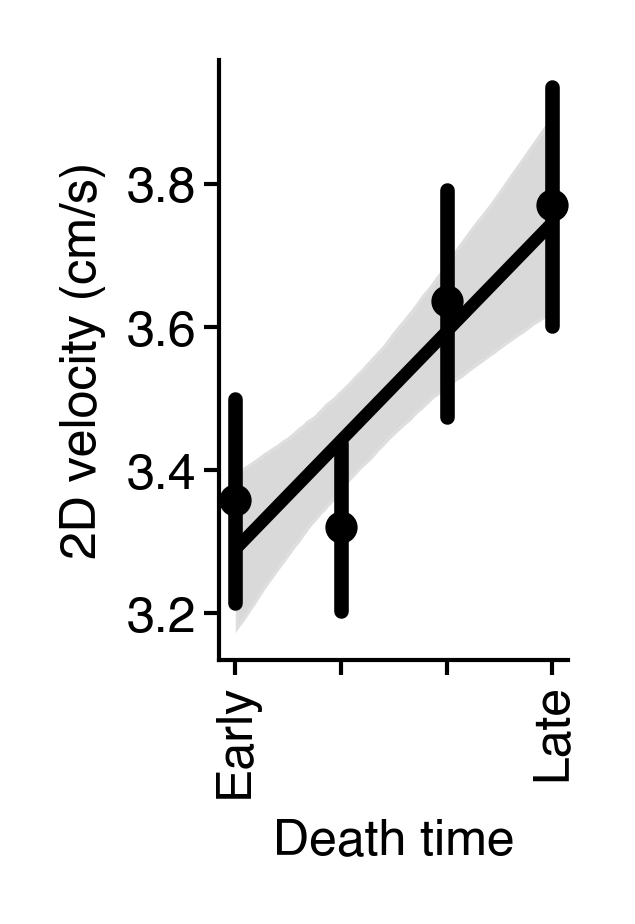

In [59]:
x = filter_velocities(mouse_velocities, 0, 20)

fig = figure(0.75, 1.3)
ax = sns.regplot(data=x, x='death_class', y='velocity_2d_mm', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="2D velocity (cm/s)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "young-velocity-vs-death");

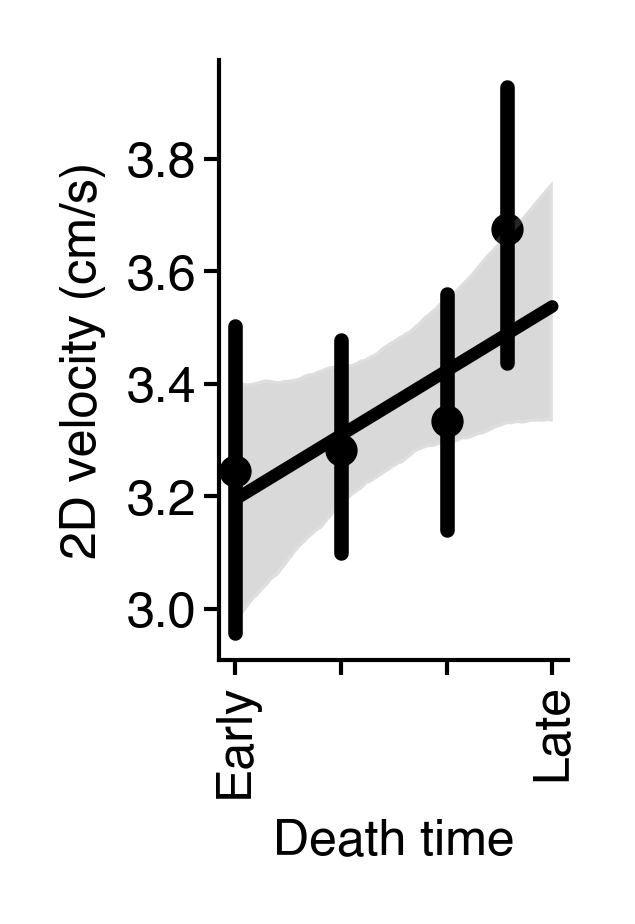

In [60]:
x = filter_velocities(mouse_velocities, 20, 37)

fig = figure(0.75, 1.3)
ax = sns.regplot(data=x, x='death_class', y='velocity_2d_mm', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="2D velocity (cm/s)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "mid-age-1-velocity-vs-death");

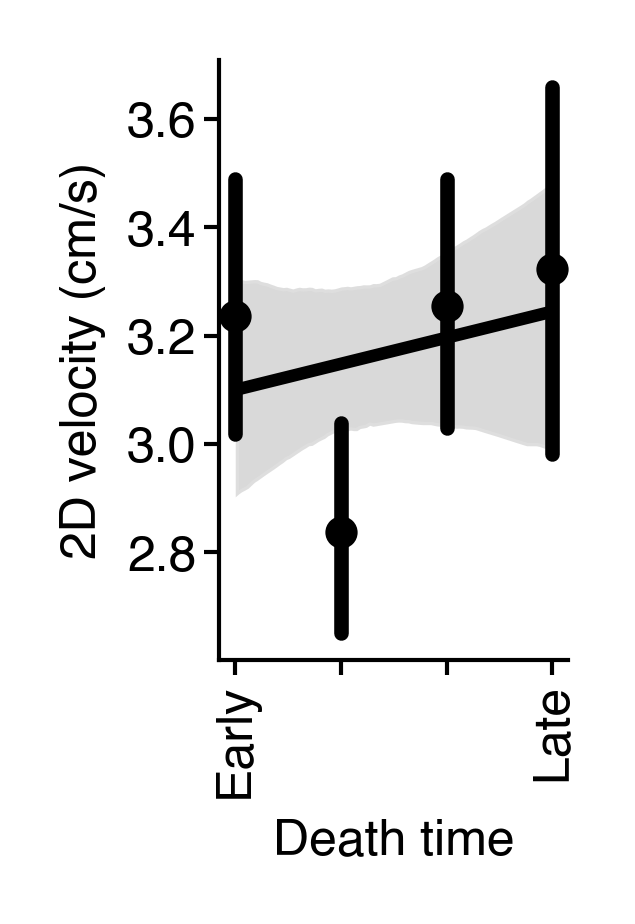

In [61]:
x = filter_velocities(mouse_velocities, 37, 56)

fig = figure(0.75, 1.3)
ax = sns.regplot(data=x, x='death_class', y='velocity_2d_mm', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="2D velocity (cm/s)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "mid-age-2-velocity-vs-death");

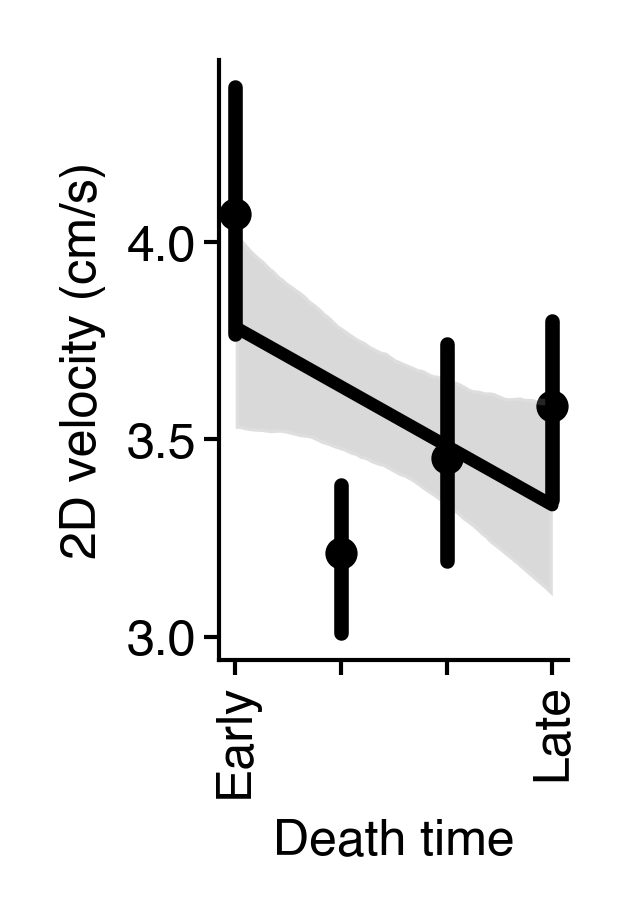

In [62]:
x = filter_velocities(mouse_velocities, 56, 71)

fig = figure(0.75, 1.3)
ax = sns.regplot(data=x, x='death_class', y='velocity_2d_mm', x_bins=6, scatter_kws=dict(s=15, linewidths=0), color='k')
ax.set(ylabel="2D velocity (cm/s)", xlabel="Death time", xticks=[0, 1, 2, 3], xticklabels=['Early', '', '', 'Late'])
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "old-age-velocity-vs-death");

In [63]:
spearmanr(x['death_class'], x['velocity_2d_mm'])

SignificanceResult(statistic=-0.14433028393301778, pvalue=0.08327264939685154)

In [64]:
def compute_vel_classifier(df, seed=0):
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", class_weight="balanced"),
    )

    preds = cross_val_predict(
        pipe,
        df[["velocity_2d_mm"]],
        df["death_class"],
        cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=seed),
    )
    return accuracy_score(df["death_class"], preds), preds


def fit_vel_classifier(data, n_fits=100, n_classes=4):
    accs = []
    for seed in range(n_fits):
        acc, p = compute_vel_classifier(data, seed=seed)
        accs.append(acc)
    print("Observed fit")
    print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

    # shuffle
    shuffs = []
    for i in tqdm(range(100)):
        shuff_df = data.copy()
        shuff_df['velocity_2d_mm'] = shuff_df['velocity_2d_mm'].sample(frac=1, replace=False, random_state=i).to_numpy()
        # shuffle ages within age chunks rather than across everything to remove individual biases
        acc, p = compute_vel_classifier(shuff_df, seed=i)
        shuffs.append(acc)
    print("Shuffle fit")
    print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))
    return accs, shuffs

Observed fit
4 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.05


/tmp/ipykernel_187495/106652125.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.4))


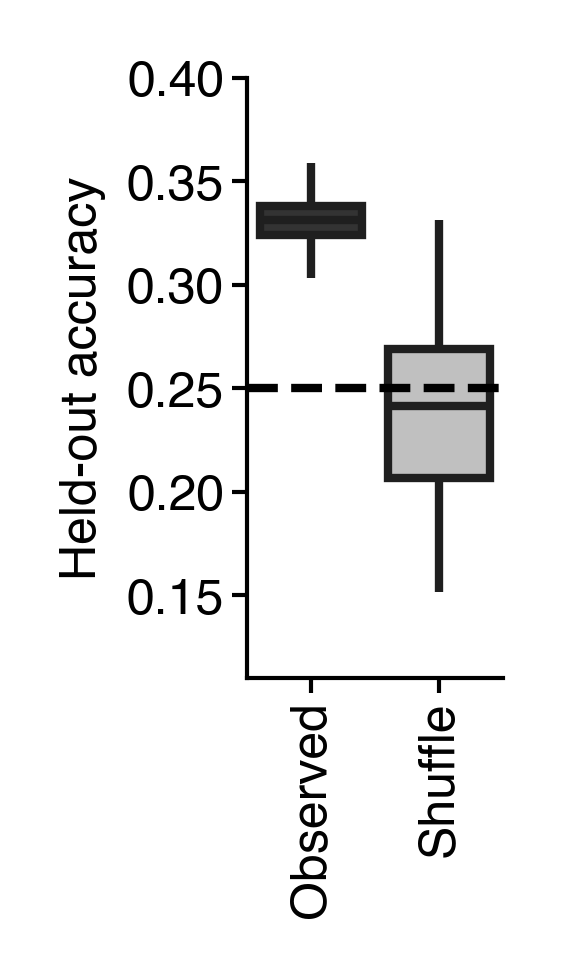

In [65]:
x = filter_velocities(mouse_velocities, 56, 71)
accs, shuffs = fit_vel_classifier(x, n_fits=1000)
plot_model(accs, shuffs, "velocity-classifier-old-age")

In [66]:
# significance of observed data
np.mean(np.array(shuffs) > np.mean(accs))

0.02

Observed fit
4 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 0.05


/tmp/ipykernel_187495/106652125.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.4))


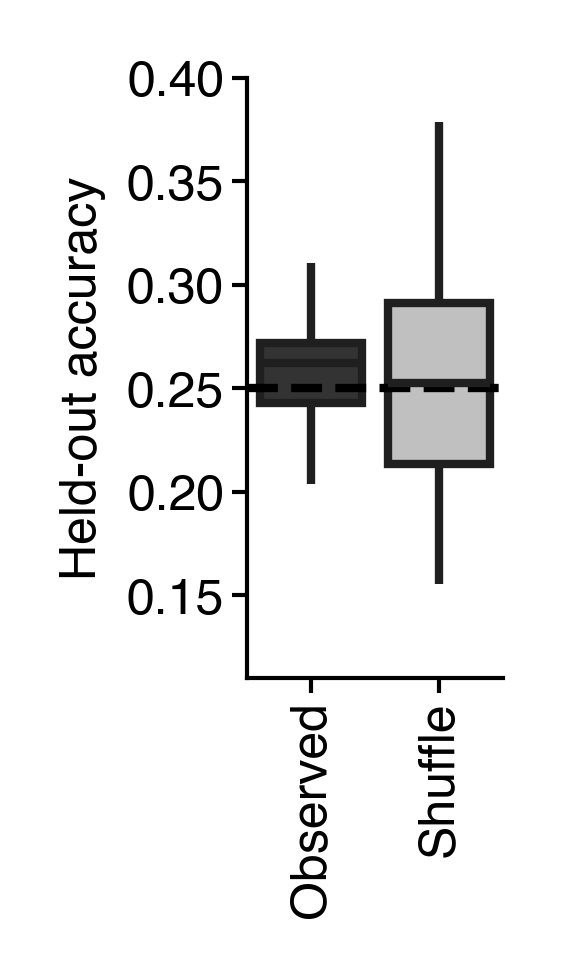

In [67]:
x = filter_velocities(mouse_velocities, 37, 56)
accs, shuffs = fit_vel_classifier(x, n_fits=1000)
plot_model(accs, shuffs, "velocity-classifier-mid-age-2")

In [68]:
# significance of observed data
np.mean(np.array(shuffs) > np.mean(accs))

0.49

Observed fit
4 -0.07


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 0.05


/tmp/ipykernel_187495/106652125.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.4))


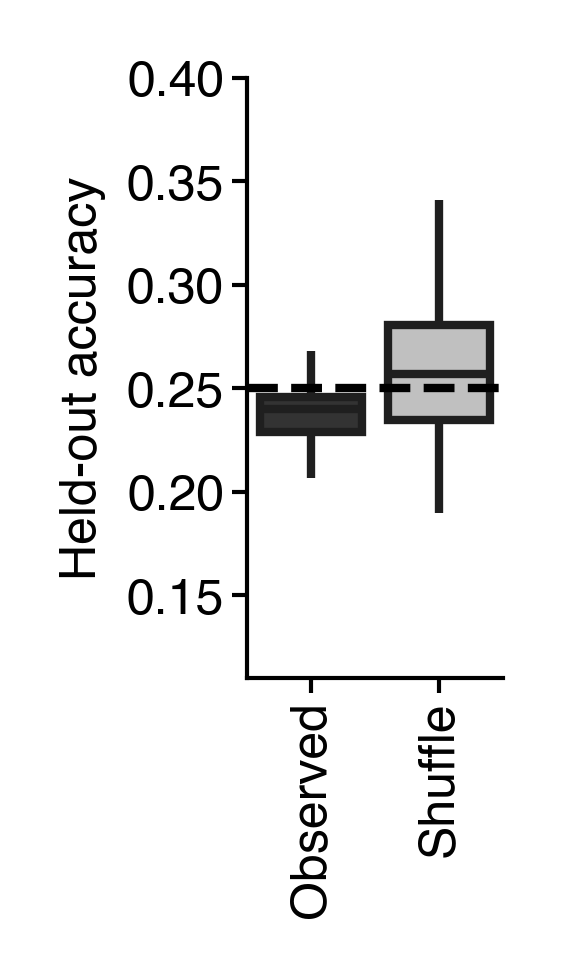

In [69]:
x = filter_velocities(mouse_velocities, 20, 37)
accs, shuffs = fit_vel_classifier(x, n_fits=1000)
plot_model(accs, shuffs, "velocity-classifier-mid-age-1")

In [70]:
# significance of observed data
np.mean(np.array(shuffs) > np.mean(accs))

0.72

Observed fit
4 0.13


  0%|          | 0/100 [00:00<?, ?it/s]

Shuffle fit
4 -0.05


/tmp/ipykernel_187495/106652125.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.4))


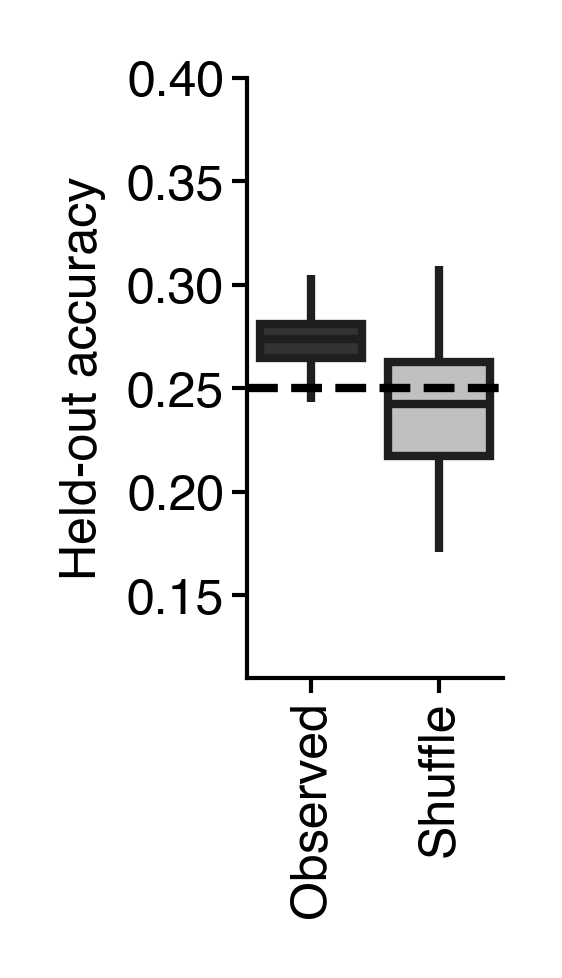

In [71]:
x = filter_velocities(mouse_velocities, 0, 20)
accs, shuffs = fit_vel_classifier(x, n_fits=1000)
plot_model(accs, shuffs, "velocity-classifier-young-age")

In [72]:
# significance of observed data
np.mean(np.array(shuffs) > np.mean(accs))

0.21